'''


    @Author: Shivraj Yelave
    @Date: 30-09-24
    @Last modified by: Shivraj Yelave
    @Last modified time: 
    @Title: Multiple Linear Regression Predict Profit


'''


### Import modules

In [2]:
import numpy as np
import pandas as pd
import statistics as st
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### import Dataset

In [3]:
df =pd.read_csv('50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [5]:
df.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

### Remove outliers if present

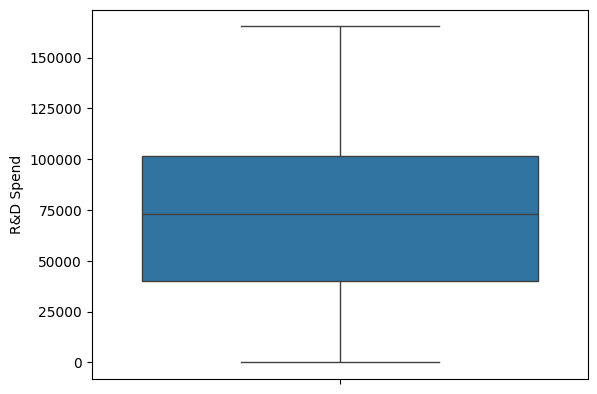

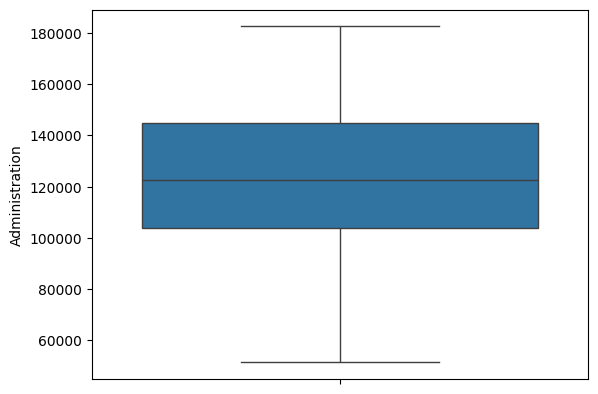

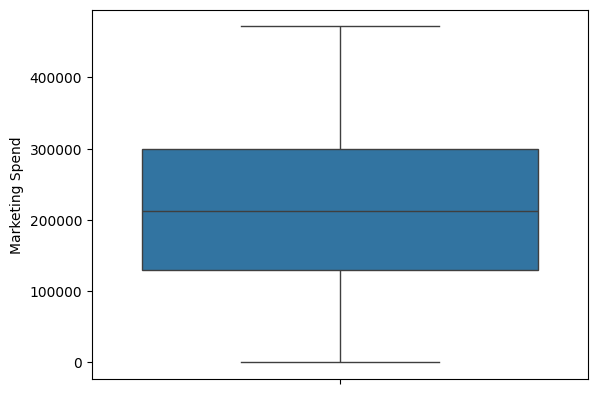

<Axes: ylabel='Profit'>

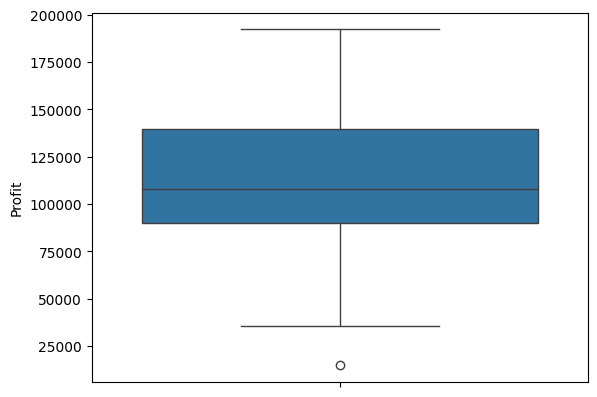

In [9]:
sns.boxplot(df['R&D Spend'])
plt.show()
sns.boxplot(df['Administration'])
plt.show()

sns.boxplot(df['Marketing Spend'])
plt.show()


sns.boxplot(df['Profit'])

(50, 5)

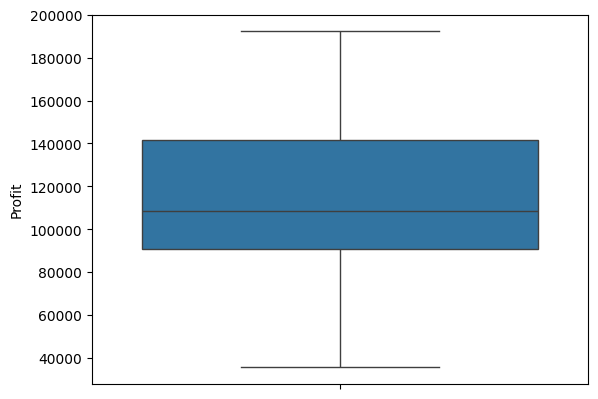

In [13]:
Q1 = df['Profit'].quantile(0.25)
Q3 = df['Profit'].quantile(0.75)
IQR = Q3 - Q1

# Filter out the outliers
filtered_df = df[(df['Profit'] >= (Q1 - 1.29 * IQR)) & (df['Profit'] <= (Q3 + 1.29 * IQR))]
sns.boxplot(filtered_df['Profit'])
df.head()
df.shape

In [16]:
df['State'].unique()

array(['New York', 'California', 'Florida'], dtype=object)

### Handle Catogrical data

In [18]:
ct = ColumnTransformer(
    transformers=([
        ('state_transformed',OneHotEncoder(),['State'])
    ])
    ,remainder='passthrough'
    )


In [19]:
transformed = ct.fit_transform(df)

# Get the names of the one-hot encoded columns
ohe_columns = ct.named_transformers_['state_transformed'].get_feature_names_out(['State'])

# Combine with the names of other columns (those that are passed through)
remaining_columns = df.drop(columns=['State']).columns.tolist()  # Get the names of remaining columns
all_columns = list(ohe_columns) + remaining_columns  # Combine all column names

# Create the transformed DataFrame
transformed_df = pd.DataFrame(transformed, columns=all_columns)

# Display the transformed DataFrame
print(transformed_df.head())

   State_California  State_Florida  State_New York  R&D Spend  Administration  \
0               0.0            0.0             1.0  165349.20       136897.80   
1               1.0            0.0             0.0  162597.70       151377.59   
2               0.0            1.0             0.0  153441.51       101145.55   
3               0.0            0.0             1.0  144372.41       118671.85   
4               0.0            1.0             0.0  142107.34        91391.77   

   Marketing Spend     Profit  
0        471784.10  192261.83  
1        443898.53  191792.06  
2        407934.54  191050.39  
3        383199.62  182901.99  
4        366168.42  166187.94  


### Scaling Dataset

In [21]:
scalar = StandardScaler()

scaled_RD_spend = scalar.fit_transform(transformed_df[['R&D Spend']])
scaled_admini= scalar.fit_transform(transformed_df[['Administration']])
scaled_Mkt_spend = scalar.fit_transform(transformed_df[['Marketing Spend']])
scaled_profit = scalar.fit_transform(transformed_df[['Profit']])

# Create a DataFrame for scaled values
scaled_df = pd.DataFrame({
    'scaled_RD_spend': scaled_RD_spend.flatten(),
    'scaled_admini': scaled_admini.flatten(),
    'scaled_Mkt_spend': scaled_Mkt_spend.flatten(),
    'scaled_profit': scaled_profit.flatten(),
    'State_California': transformed_df['State_California'],
    'State_Florida': transformed_df['State_Florida'],
    'State_New York': transformed_df['State_New York']
})

# Display the shape of the scaled DataFrame
print(scaled_df.shape)

# Display the scaled DataFrame
scaled_df.head()

(50, 7)


,scaled_RD_spend,scaled_admini,scaled_Mkt_spend,scaled_profit,State_California,State_Florida,State_New York
0,2.016411,0.560753,2.153943,2.011203,0.0,0.0,1.0
1,1.955860,1.082807,1.923600,1.999430,1.0,0.0,0.0
2,1.754364,-0.728257,1.626528,1.980842,0.0,1.0,0.0
3,1.554784,-0.096365,1.422210,1.776627,0.0,0.0,1.0
4,1.504937,-1.079919,1.281528,1.357740,0.0,1.0,0.0


In [22]:
scaled_df.isna().sum()

scaled_RD_spend     0
scaled_admini       0
scaled_Mkt_spend    0
scaled_profit       0
State_California    0
State_Florida       0
State_New York      0
dtype: int64

### Spliting Dataset

In [25]:
X = scaled_df.drop('scaled_profit',axis=1)
print(X)
y = scaled_df[['scaled_profit']]
print(y)

    scaled_RD_spend  scaled_admini  scaled_Mkt_spend  State_California  \
0          2.016411       0.560753          2.153943               0.0   
1          1.955860       1.082807          1.923600               1.0   
2          1.754364      -0.728257          1.626528               0.0   
3          1.554784      -0.096365          1.422210               0.0   
4          1.504937      -1.079919          1.281528               0.0   
5          1.279800      -0.776239          1.254210               0.0   
6          1.340066       0.932147         -0.688150               1.0   
7          1.245057       0.871980          0.932186               0.0   
8          1.030369       0.986952          0.830887               0.0   
9          1.091819      -0.456640          0.776107               1.0   
10         0.620398      -0.387599          0.149807               0.0   
11         0.593085      -1.065540          0.319834               1.0   
12         0.443260       0.215449    

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

### model selection

In [27]:
model = LinearRegression()

In [28]:
model.fit(X_train, y_train)


LinearRegression()

In [29]:
y_predict = model.predict(X_test)

### Model Evalution

In [30]:
# Evaluate the model
mse = mean_squared_error(y_test, y_predict)  # Mean Squared Error
r2 = r2_score(y_test, y_predict)  # R-squared value

# Output the results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.051510927688072985
R-squared: 0.8987266414319838
